# Mounting drive

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
file_path = "/content/drive/MyDrive/data_mfcc.pkl"

# Load data from pickle file
with open(file_path, "rb") as f:
    data = pickle.load(f)

In [ ]:
X_train = np.array(data["X_train"])
y_train = np.array(data["y_train"])
X_val = np.array(data["X_val"])
y_val = np.array(data["y_val"])
X_test = np.array(data["X_test"])
y_test = np.array(data["y_test"])
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(8000, 259, 60)
(1000, 259, 60)
(1000, 259, 60)


# Kaggle API Dataset

In [1]:
from google.colab import files

# Mengunggah file konfigurasi Kaggle API
uploaded = files.upload()

Saving kaggle.json to kaggle.json
Saving jazz.00054.wav to jazz.00054.wav


In [2]:
import shutil
import os

# Memindahkan file ke direktori Kaggle di Colab
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

In [3]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:57<00:00, 21.8MB/s]
100% 1.21G/1.21G [00:57<00:00, 22.5MB/s]


In [4]:

# Direktori tempat file-file dataset diunduh
download_dir = '/content'

!unzip gtzan-dataset-music-genre-classification.zip

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wa

In [5]:
shutil.move('jazz.00054.wav', '/content/Data/genres_original/jazz/jazz.00054.wav')

'/content/Data/genres_original/jazz/jazz.00054.wav'

In [6]:
dataset_path = '/content/Data/genres_original/'

def remove_ipynb_checkpoints(directory):
    for dirpath, dirnames, filenames in os.walk(directory):
        for dirname in dirnames:
            if dirname == '.ipynb_checkpoints':
                checkpoint_dir = os.path.join(dirpath, dirname)
                shutil.rmtree(checkpoint_dir)

# Menghapus folder .ipynb_checkpoints dari dataset
remove_ipynb_checkpoints(dataset_path)

# Main Program

In [7]:
import os
import random
import librosa
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import keras
from keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [8]:
# Global Parameter
dataset_path = '/content/Data/genres_original/'
SAMPLE_RATE = 22050
N_FFT = 2048 #int(0.025 * SAMPLE_RATE)  # 25ms frame length
WIN_LENGTH = int(0.025 * SAMPLE_RATE)
HOP_LENGTH = 512 #int(0.010 * SAMPLE_RATE)     # 10ms hop length
N_MFCC = 20  # Number of cepstral coefficients to be extracted
N_MELS =40
DURATION = 30  # Duration of each audio file
NUM_SEGMENTS = 10  # Number of segments per audio file
TEST_SPLIT = 0.2  # Percentage of test set

In [9]:
preprocess = {
    "mapping" : [],
    "train" : {
        "features" : [],
        "labels" : []
    },
    "test" : {
        "features" : [],
        "labels" : []
    },
    "val" : {
        "features" : [],
        "labels" : []
    }
}

In [10]:
def white_noice(audio) :
  duration = librosa.get_duration(y=audio, sr=SAMPLE_RATE)
  noise = np.random.normal(0, audio.std(), audio.size)
  audio = audio + noise * 0.1  # 10% noise

  stretch_factor = len(audio) / (SAMPLE_RATE * DURATION)
  audio = librosa.effects.time_stretch(y=audio, rate=stretch_factor)
  print("Duration: ", librosa.get_duration(y=audio, sr=SAMPLE_RATE))

  return audio

In [11]:
def silent_remover(audio) :
  # Set amplitude threshold
  amplitude_threshold = 0.00316 # -50dB

  # Create an array of silent frames based on amplitude threshold
  silent_frames = np.abs(audio) < amplitude_threshold

  # Create an array of non-silent frames by inverting the silent frames
  non_silent_frames = np.logical_not(silent_frames)

  # Extract non-silent audio frames
  non_silent_audio = audio[non_silent_frames]

  # Calculate the time stretch factor
  stretch_factor = len(non_silent_audio) / (SAMPLE_RATE * DURATION)

  # Apply time stretching or compression
  stretched_audio = librosa.effects.time_stretch(y=non_silent_audio, rate=stretch_factor)

  return stretched_audio


In [12]:
def stretch(audio) :
  # print("\n MASUKK")
  # Calculate the time stretch factor
  stretch_factor = len(audio) / (SAMPLE_RATE * DURATION)

  # Apply time stretching or compression
  stretched_audio = librosa.effects.time_stretch(y=audio, rate=stretch_factor)
  duration = librosa.get_duration(y=stretched_audio, sr=SAMPLE_RATE)
  # print("durasi :", duration)
  return stretched_audio

In [13]:
def process (audio) :
    dummy = []

    stretched_audio = silent_remover(audio)
    # print(len(stretched_audio))
    for s in range(NUM_SEGMENTS) :
        start_sample = s * len(stretched_audio) // NUM_SEGMENTS
        end_sample = (s + 1) * len(stretched_audio) // NUM_SEGMENTS
        # print(start_sample, end_sample)
        segment_audio = stretched_audio[start_sample:end_sample]
        dummy.append(segment_audio)

    return dummy

In [14]:
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

    # Pastikan kita tidak berada di root level
    if dirpath is not dataset_path:
        # Simpan nama genre ke mapping
        dirpath_components = dirpath.split("/")
        semantic_label = dirpath_components[-1]
        preprocess["mapping"].append(semantic_label)
        print("\nProcessing {}".format(semantic_label))

        feature_dummies = []
        label_dummies = []

        # Proses file audio untuk tiap genre
        for f in filenames:
            # Load audio file
            file_path = os.path.join(dirpath, f)
            audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            # Process audio file
            audio = process(audio)

            for s,a in enumerate(audio) :
                feature_dummies.append(a)
                label_dummies.append(i-1)
                print("{}, segment:{}".format(file_path, s+1))

        # Split dataset menjadi training, validation, dan test set dengan train_test_split
        feature_train, feature_temp, label_train, label_temp = train_test_split(feature_dummies, label_dummies, test_size=TEST_SPLIT, random_state=42)
        feature_test, feature_val, label_test, label_val = train_test_split(feature_temp, label_temp, test_size=0.5, random_state=42)

        # Menambahkan data ke dalam dictionary
        preprocess["train"]["features"].extend(feature_train)
        preprocess["train"]["labels"].extend(label_train)
        preprocess["test"]["features"].extend(feature_test)
        preprocess["test"]["labels"].extend(label_test)
        preprocess["val"]["features"].extend(feature_val)
        preprocess["val"]["labels"].extend(label_val)


Output streaming akan dipotong hingga 5000 baris terakhir.
/content/Data/genres_original/reggae/reggae.00082.wav, segment:9
/content/Data/genres_original/reggae/reggae.00082.wav, segment:10
/content/Data/genres_original/reggae/reggae.00000.wav, segment:1
/content/Data/genres_original/reggae/reggae.00000.wav, segment:2
/content/Data/genres_original/reggae/reggae.00000.wav, segment:3
/content/Data/genres_original/reggae/reggae.00000.wav, segment:4
/content/Data/genres_original/reggae/reggae.00000.wav, segment:5
/content/Data/genres_original/reggae/reggae.00000.wav, segment:6
/content/Data/genres_original/reggae/reggae.00000.wav, segment:7
/content/Data/genres_original/reggae/reggae.00000.wav, segment:8
/content/Data/genres_original/reggae/reggae.00000.wav, segment:9
/content/Data/genres_original/reggae/reggae.00000.wav, segment:10
/content/Data/genres_original/reggae/reggae.00041.wav, segment:1
/content/Data/genres_original/reggae/reggae.00041.wav, segment:2
/content/Data/genres_original

In [15]:
def mfcc(audio) :
  mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)

  delta_mfcc = librosa.feature.delta(mfcc)
  delta2_mfcc = librosa.feature.delta(mfcc, order=2)
  concanated_mfcc = np.vstack((mfcc, delta_mfcc, delta2_mfcc))
  concanated_mfcc = concanated_mfcc.T
  return concanated_mfcc.tolist()

In [16]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

for i in range(len(preprocess["train"]["features"])) :
    feature = preprocess["train"]["features"][i]
    label = preprocess["train"]["labels"][i]

    extraction = mfcc(feature)

    X_train.append(extraction)
    y_train.append(label)

for i in range(len(preprocess["val"]["features"])) :
    feature = preprocess["val"]["features"][i]
    label = preprocess["val"]["labels"][i]

    extraction = mfcc(feature)

    X_val.append(extraction)
    y_val.append(label)

for i in range(len(preprocess["test"]["features"])) :
    feature = preprocess["test"]["features"][i]
    label = preprocess["test"]["labels"][i]

    extraction = mfcc(feature)

    X_test.append(extraction)
    y_test.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(8000, 130, 60)
(1000, 130, 60)
(1000, 130, 60)


In [17]:
def build_model(input_shape):
    model = keras.Sequential()

    # First Bidirectional LSTM layer
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True), input_shape=input_shape))
    model.add(keras.layers.LayerNormalization())  # Tambahkan Layer Normalization di sini

    # Global Average Pooling layer (or Global Max Pooling)
    model.add(keras.layers.GlobalAveragePooling1D())


    # Output layer
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

In [18]:
def acc_plot(history):

        fig, axs = plt.subplots()

        # create accuracy subplot
        axs.plot(history.history["accuracy"], label="train accuracy")
        axs.plot(history.history["val_accuracy"], label="val accuracy")
        axs.set_ylabel("Accuracy")
        axs.legend(loc="lower right")
        axs.set_title("Accuracy eval")
        plt.figure(figsize=(10, 5))
        plt.show()

def loss_plot(history) :
        fig, axs = plt.subplots()

        # create loss subplot
        axs.plot(history.history["loss"], label="train loss")
        axs.plot(history.history["val_loss"], label="val loss")
        axs.set_ylabel("Loss")
        axs.set_xlabel("Epoch")
        axs.legend(loc="upper right")
        axs.set_title("Loss eval")
        plt.figure(figsize=(10, 5))
        plt.show()

In [19]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 130, 1024)         2347008   
 al)                                                             
                                                                 
 layer_normalization (Layer  (None, 130, 1024)         2048      
 Normalization)                                                  
                                                                 
 global_average_pooling1d (  (None, 1024)              0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
Total params: 2359306 (9.00 MB)
Trainable params: 2359306 (9.00 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [20]:

# compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# add callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/models/jurnal2.h5', save_best_only=True)

# train model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=30, callbacks=[early_stopping, model_checkpoint])




Epoch 1/30
63/63 [==============================] - 13s 131ms/step - loss: 1.3656 - accuracy: 0.5386 - val_loss: 0.9793 - val_accuracy: 0.6700
Epoch 2/30
 1/63 [..............................] - ETA: 5s - loss: 0.8524 - accuracy: 0.6875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 7s 107ms/step - loss: 0.7488 - accuracy: 0.7484 - val_loss: 0.7245 - val_accuracy: 0.7630
Epoch 3/30
63/63 [==============================] - 7s 107ms/step - loss: 0.5080 - accuracy: 0.8342 - val_loss: 0.5573 - val_accuracy: 0.8220
Epoch 4/30
63/63 [==============================] - 7s 107ms/step - loss: 0.3396 - accuracy: 0.8963 - val_loss: 0.4466 - val_accuracy: 0.8610
Epoch 5/30
63/63 [==============================] - 7s 107ms/step - loss: 0.2394 - accuracy: 0.9286 - val_loss: 0.3714 - val_accuracy: 0.8810
Epoch 6/30
63/63 [==============================] - 7s 107ms/step - loss: 0.1462 - accuracy: 0.9604 - val_loss: 0.3470 - val_accuracy: 0.8840
Epoch 7/30
63/63 [==============================] - 7s 108ms/step - loss: 0.1011 - accuracy: 0.9756 - val_loss: 0.3134 - val_accuracy: 0.8920
Epoch 8/30
63/63 [==============================] - 7s 107ms/step - loss: 0.0727 - accuracy: 0.9824 - val_loss: 0.3111 - val_accuracy: 0.9000
Epoch 9/30
63/63 

In [21]:
history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch
history_df

,loss,accuracy,val_loss,val_accuracy,epoch
0,1.365604,0.538625,0.979343,0.670,0
1,0.748846,0.748375,0.724473,0.763,1
2,0.507970,0.834250,0.557295,0.822,2
3,0.339569,0.896250,0.446601,0.861,3
4,0.239429,0.928625,0.371405,0.881,4
5,0.146168,0.960375,0.347020,0.884,5
6,0.101118,0.975625,0.313391,0.892,6
7,0.072667,0.982375,0.311114,0.900,7
8,0.046672,0.989625,0.289465,0.913,8
9,0.046503,0.989500,0.316210,0.892,9


32/32 [==============================] - 1s 21ms/step - loss: 0.2266 - accuracy: 0.9360
Train accuracy: 99.87%
Train loss:  0.35%
Validation accuracy: 92.90%
Validation loss: 27.32%
Test accuracy: 93.60%
Test loss: 22.66%


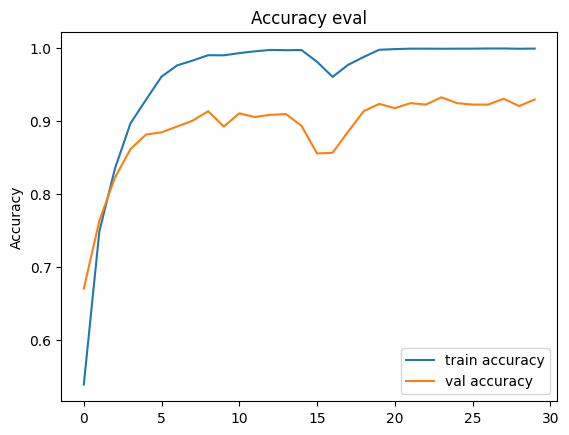

<Figure size 1000x500 with 0 Axes>

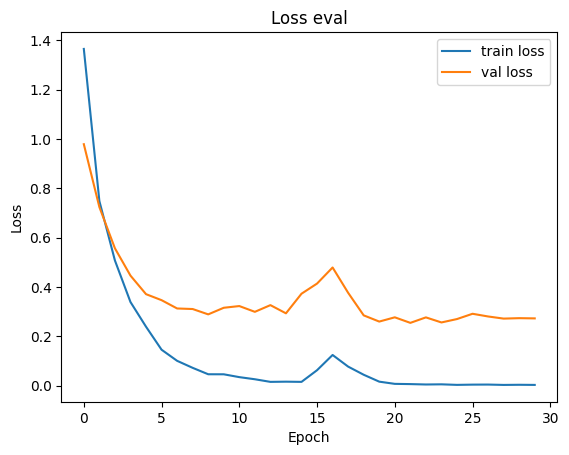

<Figure size 1000x500 with 0 Axes>

In [22]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
print("Train accuracy: {:5.2f}%".format(100 * train_acc[-1]))
print("Train loss: {:5.2f}%".format(100 * train_loss[-1]))
print("Validation accuracy: {:5.2f}%".format(100 * val_acc[-1]))
print("Validation loss: {:5.2f}%".format(100 * val_loss[-1]))
print("Test accuracy: {:5.2f}%".format(100 * test_acc))
print("Test loss: {:5.2f}%".format(100 * test_loss))
acc_plot(history)
loss_plot(history)

32/32 [==============================] - 1s 22ms/step
Confusion Matrix:


<Axes: >

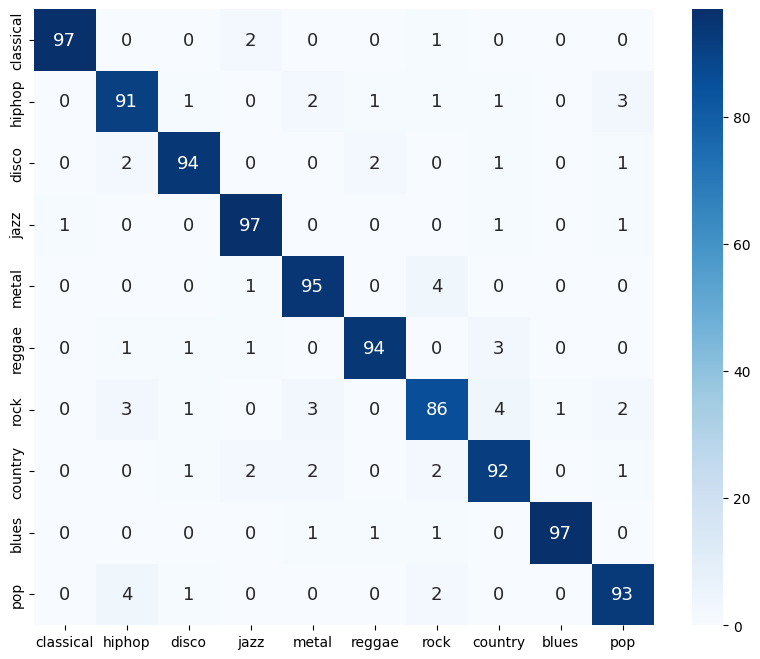

In [28]:
y_pred = model.predict(X_test)
genre_labels = preprocess['mapping']
confusion = confusion_matrix(y_test, y_pred.argmax(axis=1))
print('Confusion Matrix:')

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=genre_labels, yticklabels=genre_labels, annot_kws={"size": 13})

In [24]:
print('Classification Report')

print(classification_report(y_test, y_pred.argmax(axis=1), target_names=genre_labels))

Classification Report
              precision    recall  f1-score   support

   classical       0.99      0.97      0.98       100
      hiphop       0.90      0.91      0.91       100
       disco       0.95      0.94      0.94       100
        jazz       0.94      0.97      0.96       100
       metal       0.92      0.95      0.94       100
      reggae       0.96      0.94      0.95       100
        rock       0.89      0.86      0.87       100
     country       0.90      0.92      0.91       100
       blues       0.99      0.97      0.98       100
         pop       0.92      0.93      0.93       100

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



# Experiment Funct

In [ ]:
def pre_mfcc(signal):


    # Apply pre-emphasis filter
    pre_emphasis = 0.97
    emphasized_signal = np.append(
        signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # Apply framing
    frame_size = 0.025
    frame_stride = 0.01
    frame_length, frame_step = frame_size * sr, frame_stride * sr
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Apply windowing
    frames *= np.hamming(frame_length)

    # Apply Fourier Transform and Power Spectrum
    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Apply Mel filterbank
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sr)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(
        filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)

    # Apply mean normalization
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

    return filter_banks


In [ ]:
def extract_mfcc(signal):
    # Apply Discrete Cosine Transform
    filter_banks = pre_mfcc(signal)
    num_ceps = 20
    mfcc = np.zeros((filter_banks.shape[0], num_ceps))
    for i in range(num_ceps):
        n = np.arange(filter_banks.shape[1])
        lift = 1 + (num_ceps / 2) * np.sin(np.pi * i / num_ceps)
        mfcc[:, i] = lift * \
            np.dot(filter_banks, np.cos(np.pi * i *
                   (n + 0.5) / filter_banks.shape[1]))


    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(delta_mfcc, order=2)
    concanated_mfcc = np.hstack((mfcc, delta_mfcc))
    return concanated_mfcc

In [ ]:
def librosa_pre_mfcc(signal, sr=22050, n_fft=512, hop_length=256):
    # Pre-emphasis filter
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01
    frame_length = int(round(frame_size * sr))
    frame_step = int(round(frame_stride * sr))
    frames = librosa.util.frame(emphasized_signal, frame_length=frame_length, hop_length=frame_step)

    # Apply windowing (using Hamming window)
    frames *= np.hamming(frame_length)[:, np.newaxis]

    # Apply Fourier Transform and Power Spectrum
    mag_frames = np.abs(librosa.stft(emphasized_signal, n_fft=n_fft, hop_length=hop_length)) ** 2

    # Apply Mel filterbank
    nfilt = 40
    mel_filterbank = librosa.filters.mel(sr, n_fft, n_mels=nfilt)
    filter_banks = np.dot(mel_filterbank, mag_frames)

    # Convert to dB and apply mean normalization
    filter_banks = librosa.power_to_db(filter_banks, ref=np.max)
    filter_banks -= np.mean(filter_banks, axis=0)

    return filter_banks

def librosa_extract_mfcc(signal, sr=22050, n_fft=512, hop_length=256, n_mfcc=20):
    # Compute Mel filterbanks
    filter_banks = librosa_pre_mfcc(signal, sr=sr, n_fft=n_fft, hop_length=hop_length)

    # Compute MFCC using DCT
    mfcc = librosa.feature.mfcc(sr=sr, S=filter_banks, n_mfcc=n_mfcc)

    # Compute delta and delta-delta MFCC
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    # Concatenate MFCC with delta and delta-delta MFCC
    concatenated_mfcc = np.vstack((mfcc, delta_mfcc, delta2_mfcc))

    return concatenated_mfcc.T  # Transpose to have frames as rows and coefficients as columns


In [ ]:
def mel_spectrogram(audio) :
  mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, win_length=WIN_LENGTH)
  mel_spectrogram_features = librosa.power_to_db(mel_spectrogram, ref=np.max)
  mel_spectrogram_features = mel_spectrogram_features.T

  return mel_spectrogram_features